**Helpful Links: Where the Data Lives**

Open Academic Society: [Project Page](https://www.openacademic.ai/oag/)

Microsoft Research: [MS Academic Graph](https://www.microsoft.com/en-us/research/project/microsoft-academic-graph/)

In [50]:
import pandas as pd
from sys import getsizeof

In [51]:
model_df = pd.read_json('data/mag_papers_0/mag_subset20K.txt', lines=True)

In [52]:
# filter out non-English articles
# keep abstract, authors, fos, keywords, year, title

model_df = model_df[model_df.lang == 'en'].drop(['doc_type', 'doi', 'id', 'issue', 'lang', 'n_citation', 'page_end', 
                            'page_start', 'publisher', 'references', 'url', 'venue', 'volume'], axis=1)

model_df.shape

(10399, 6)

We will start with a simple example of building a recommender with just a few fields, building sparse arrays of available features to calculate for the Jaccard similary between papers. We will see if reasonably similar papers can be found in a timely manner.

# (2) engineering our current features, pipe, outcome

Numerical features broadly distributed across a dataset can unnecessarily increase the size of our feature space. Let's wrangle this in first.

In [53]:
model_df['year'].tail()

19994    1951
19995    2017
19997    1971
19998    1986
19999    2015
Name: year, dtype: int64

In [54]:
print("Year spread: ", model_df['year'].min()," - ", model_df['year'].max())
print("Quantile spread:\n", model_df['year'].quantile([0.25, 0.5, 0.75]))

Year spread:  1831  -  2017
Quantile spread:
 0.25    1990.0
0.50    2005.0
0.75    2012.0
Name: year, dtype: float64


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [56]:
%matplotlib inline

Text(0,0.5,'Occurrence')

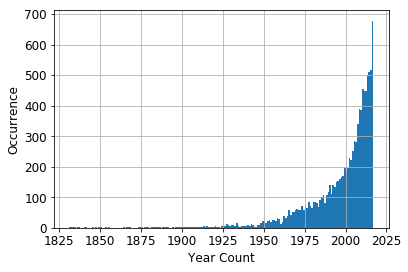

In [57]:
# plot years to see the distribution
fig, ax = plt.subplots()
model_df['year'].hist(ax=ax, bins= model_df['year'].max() - model_df['year'].min())
ax.tick_params(labelsize=12)
ax.set_xlabel('Year Count', fontsize=12)
ax.set_ylabel('Occurrence', fontsize=12)

We can see from the uneven distribution that this is an excellent candidate for binning and dummy coding. Lucky for us, pandas can do all these things using built-in functions. Our results will be easy to interpret.

## years: binning + dummy coding

In [58]:
# we'll base our bins on the range of the variable, rather than the unique number of features
model_df['year'].max() - model_df['year'].min()

186

In [59]:
# binning here (by 10 years)
bins = int(round((model_df['year'].max() - model_df['year'].min()) / 10))

temp_df = pd.DataFrame(index = model_df.index)
temp_df['yearBinned'] = pd.cut(model_df['year'].tolist(), bins, precision = 0)

In [60]:
# now we only have as many bins as we created(grouping together by 10 years)
print('We have reduced from', len(model_df['year'].unique()),
      'to', len(temp_df['yearBinned'].values.unique()), 'features representing the year.')

We have reduced from 156 to 19 features representing the year.


In [61]:
X_yrs = pd.get_dummies(temp_df['yearBinned'])
X_yrs.head()

,"(1831.0, 1841.0]","(1841.0, 1851.0]","(1851.0, 1860.0]","(1860.0, 1870.0]","(1870.0, 1880.0]","(1880.0, 1890.0]","(1890.0, 1900.0]","(1900.0, 1909.0]","(1909.0, 1919.0]","(1919.0, 1929.0]","(1929.0, 1939.0]","(1939.0, 1948.0]","(1948.0, 1958.0]","(1958.0, 1968.0]","(1968.0, 1978.0]","(1978.0, 1988.0]","(1988.0, 1997.0]","(1997.0, 2007.0]","(2007.0, 2017.0]"
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [62]:
X_yrs.columns.categories

IntervalIndex([(1831.0, 1841.0], (1841.0, 1851.0], (1851.0, 1860.0], (1860.0, 1870.0], (1870.0, 1880.0] ... (1968.0, 1978.0], (1978.0, 1988.0], (1988.0, 1997.0], (1997.0, 2007.0], (2007.0, 2017.0]]
              closed='right',
              dtype='interval[float64]')

Text(0,0.5,'Counts')

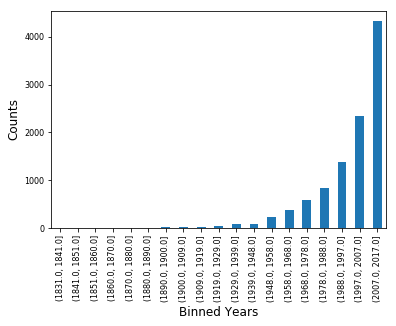

In [64]:
# let's look at the new distribution
fig, ax = plt.subplots()
X_yrs.sum().plot.bar(ax = ax)
ax.tick_params(labelsize=8)
ax.set_xlabel('Binned Years', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

We have preserved the underlying distribution of the original variable through binning by decades. If we desired to use a method that would benefit from a different distribution, we could alter our binning choices to change how this variable presents itself to the model. Since we are using a cosine similarity, this is fine.

Let's move on to the next feature we originally included in our model.

## fields of study: convert to sparse array

This feature contributed significantly to the original model's size and processing time. We we will aim to reduce these. 

Let's leverage work we have already done. We have a sparse array of parsed field of study fields. We'll convert from a pandas DataFrame to a numpy sparse array to see if that helps to save on computation time.

In [65]:
unique_fos = sorted(list({ feature
                          for paper_row in model_df.fos.fillna('0')
                          for feature in paper_row }))

In [67]:
def feature_array(x, unique_array):
    row_dict = {}
    for i in x.index:
        var_dict = {}
        
        for j in range(len(unique_array)):
            if type(x[i]) is list:
                if unique_array[j] in x[i]:
                    var_dict.update({unique_array[j]: 1})
                else:
                    var_dict.update({unique_array[j]: 0})
            else:    
                if unique_array[j] == str(x[i]):
                    var_dict.update({unique_array[j]: 1})
                else:
                    var_dict.update({unique_array[j]: 0})
        
        row_dict.update({i : var_dict})
    
    feature_df = pd.DataFrame.from_dict(row_dict, dtype='str').T
    
    return feature_df

In [68]:
%time fos_features = feature_array(model_df['fos'], unique_fos)

CPU times: user 28min 55s, sys: 13.3 s, total: 29min 8s
Wall time: 29min 38s


In [69]:
fos_features.head(2)

,0,0-10 V lighting control,1/N expansion,10G-PON,14-3-3 protein,2-choice hashing,20th-century philosophy,2D computer graphics,2DEG,3-D Secure,...,k-nearest neighbors algorithm,m-derived filter,microRNA,pH,photoperiodism,route,strictfp,string,Ćuk converter,μ operator
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
X_fos = fos_features.values

In [71]:
# We can see how this will make a difference in the future by looking at the size of each
print('Our pandas Series, in bytes: ', getsizeof(fos_features))
print('Our hashed numpy array, in bytes: ', getsizeof(X_fos))

Our pandas Series, in bytes:  2530632380
Our hashed numpy array, in bytes:  112


Putting it back together, we'll pipe our features together and re-run our recommender to see if we have improved results. Since we are starting to use sklearn, we'll take advantage of their cosine similarity function, reducing the computational time by only focusing on one item at a time.

In [72]:
X_yrs.shape[1] + X_fos.shape[1]

7623

In [73]:
# now looking at 10399 x  7623 array for our feature space

%time second_features = np.append(X_fos, X_yrs, axis = 1)

second_size = getsizeof(second_features)

print('Size of second feature array, in bytes: ', second_size)

CPU times: user 700 ms, sys: 1.02 s, total: 1.72 s
Wall time: 2.14 s
Size of second feature array, in bytes:  634172728


In [74]:
print("The power of feature engineering saves us, in bytes: ", 802239497 - second_size)

The power of feature engineering saves us, in bytes:  168066769


Converting between pandas DataFrames and numpy matrices can make indices tricky. We have the same size index, but the index assigments are not the same.

pandas assists with this differentiating between .iloc, .loc and .get_loc. 

.loc will return the index based on the original pandas DataFrame, allowing us to reference specific papers. We use .iloc to specify the integer location, which is the same index as our numpy array. .get_loc assists us to find the integer location when we know the DataFrame index.

In [75]:
model_df.loc[21]

abstract    A microprocessor includes hardware registers t...
authors                      [{'name': 'Mark John Ebersole'}]
fos         [Embedded system, Parallel computing, Computer...
keywords                                                  NaN
title       Microprocessor that enables ARM ISA program to...
year                                                     2013
Name: 21, dtype: object

In [76]:
model_df.iloc[21]

abstract                                                  NaN
authors     [{'name': 'Nicola M. Heller'}, {'name': 'Steph...
fos         [Biology, Medicine, Post-transcriptional regul...
keywords    [glucocorticoids, post transcriptional regulat...
title       Post-transcriptional regulation of eotaxin by ...
year                                                     2002
Name: 30, dtype: object

In [77]:
model_df.index.get_loc(30)

21

In [78]:
from sklearn.metrics.pairwise import cosine_similarity

def piped_collab_filter(features_matrix, index, top_n):
                
    item_similarities = 1 - cosine_similarity(features_matrix[index:index+1], features_matrix).flatten() 
    related_indices = [i for i in item_similarities.argsort()[::-1] if i != index]

    return [(index, item_similarities[index]) for index in related_indices][0:top_n]

def paper_recommender(items_df, paper_index, top_n):
    if paper_index in model_df.index:
        
        print('Based on the paper:')
        print('Paper index = ', model_df.loc[paper_index].name)
        print('Title :', model_df.loc[paper_index]['title'])
        print('FOS :', model_df.loc[paper_index]['fos'])
        print('Year :', model_df.loc[paper_index]['year'])
        print('Abstract :', model_df.loc[paper_index]['abstract'])
        print('Authors :', model_df.loc[paper_index]['authors'], '\n')
        
        # define the location index for the DataFrame index requested
        array_ix = model_df.index.get_loc(paper_index)

        top_results = piped_collab_filter(items_df, array_ix, top_n)
        
        print('\nTop',top_n,'results: ') 
        
        order = 1
        for i in range(len(top_results)):
            print(order,'. Paper index = ', model_df.iloc[top_results[i][0]].name)
            print('Similarity score: ', top_results[i][1])
            print('Title :', model_df.iloc[top_results[i][0]]['title'])
            print('FOS :', model_df.iloc[top_results[i][0]]['fos'])
            print('Year :', model_df.iloc[top_results[i][0]]['year'])
            print('Abstract :', model_df.iloc[top_results[i][0]]['abstract'])
            print('Authors :', model_df.iloc[top_results[i][0]]['authors'], '\n')
            if order < top_n: order += 1
    
    else:
        print('Whoops! Choose another paper. Try something from here: \n', model_df.index[100:200])

In [79]:
paper_recommender(second_features, 2, 3)

Based on the paper:
Paper index =  2
Title : Should endometriosis be an indication for intracytoplasmic sperm injection (ICSI) in fresh IVF cycles
FOS : nan
Year : 2015
Abstract : nan
Authors : [{'name': 'Jovana P. Lekovich', 'org': 'Weill Cornell Medical College, New York, NY'}, {'name': 'G.D. Palermo', 'org': 'Weill Medical College of Cornell University, New York, NY'}, {'name': 'Nigel Pereira', 'org': 'The Ronald O. Perelman and Claudia Cohen Center, New York, NY'}, {'name': 'Zev Rosenwaks', 'org': 'Weill Cornell Medical College, New York, NY'}] 


Top 3 results: 
1 . Paper index =  10055
Similarity score:  1.0
Title : [Diagnosis of cerebral tumors; comparative studies on arteriography, ventriculography and electroencephalography].
FOS : ['Radiology', 'Pathology', 'Surgery']
Year : 1953
Abstract : nan
Authors : [{'name': 'Antoine'}, {'name': 'Lepoire'}, {'name': 'Schoumacker'}] 

2 . Paper index =  11771
Similarity score:  1.0
Title : A Study of Special Functions in the Theory of Ec

To be honest, I don't think we are doing a very good job. Let's keep going to see if we can make this better.

## (3) abstract: stopwords, frequency based filtering (tf-idf?)

In [80]:
# need to fill in NaN for sklearn
filled_df = model_df.fillna('None')

In [81]:
# abstract: stopwords, frequency based filtering (tf-idf?)
filled_df['abstract'].head()

0    A system and method for maskless direct write ...
1                                                 None
2                                                 None
5                                                 None
7    Full textFull text is available as a scanned c...
Name: abstract, dtype: object

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
X_abstract = vectorizer.fit_transform(filled_df['abstract'])

X_abstract

<10399x48516 sparse matrix of type '<class 'numpy.float64'>'
	with 374055 stored elements in Compressed Sparse Row format>

In [83]:
print("n_samples: %d, n_features: %d" % X_abstract.shape)

n_samples: 10399, n_features: 48516


Let's combine these new features with our last engineered features to see if we are on the right track.

In [84]:
X_yrs.shape[1] + X_fos.shape[1] + X_abstract.shape[1]

56139

In [85]:
# now looking at 10399 x  356139 array for our feature space

%time third_features = np.append(second_features, X_abstract.toarray(), axis = 1)

CPU times: user 19.7 s, sys: 43.8 s, total: 1min 3s
Wall time: 1min 55s


In [40]:
paper_recommender(third_features, 2, 3)

Based on the paper:
Paper index =  2
Title : Should endometriosis be an indication for intracytoplasmic sperm injection (ICSI) in fresh IVF cycles
FOS : nan
Year : 2015
Abstract : nan
Authors : [{'name': 'Jovana P. Lekovich', 'org': 'Weill Cornell Medical College, New York, NY'}, {'name': 'G.D. Palermo', 'org': 'Weill Medical College of Cornell University, New York, NY'}, {'name': 'Nigel Pereira', 'org': 'The Ronald O. Perelman and Claudia Cohen Center, New York, NY'}, {'name': 'Zev Rosenwaks', 'org': 'Weill Cornell Medical College, New York, NY'}] 


Top 3 results: 
1 . Paper index =  10055
Similarity score:  1.0
Title : [Diagnosis of cerebral tumors; comparative studies on arteriography, ventriculography and electroencephalography].
FOS : ['Radiology', 'Pathology', 'Surgery']
Year : 1953
Abstract : nan
Authors : [{'name': 'Antoine'}, {'name': 'Lepoire'}, {'name': 'Schoumacker'}] 

2 . Paper index =  11773
Similarity score:  1.0
Title : Studies of powder flow using a recording powder 

## authors: One-Hot Encoding using sklearn DictVectorizer()

In [41]:
authors_df = pd.DataFrame(filled_df.authors)
authors_df.head()

,authors
0,None
1,[{'name': 'Ahmed M. Alluwaimi'}]
2,"[{'name': 'Jovana P. Lekovich', 'org': 'Weill ..."
5,[{'name': 'George C. Sponsler'}]
7,[{'name': 'M. T. Richards'}]


In [42]:
import json

In [43]:
authors_list = []

for row in authors_df.itertuples():
    # create a dictionary from each Series index
    if type(row.authors) is str:
        y = {'None': row.Index}
    if type(row.authors) is list:
        # add these keys + values to our running dictionary    
        y = dict.fromkeys(row.authors[0].values(), row.Index)
    authors_list.append(y)

In [44]:
authors_list[0:5]

[{'None': 0},
 {'Ahmed M. Alluwaimi': 1},
 {'Jovana P. Lekovich': 2, 'Weill Cornell Medical College, New York, NY': 2},
 {'George C. Sponsler': 5},
 {'M. T. Richards': 7}]

In [45]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
D = authors_list
X_authors = v.fit_transform(D)

X_authors

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [46]:
print("n_samples: %d, n_features: %d" % X_authors.shape)

n_samples: 10399, n_features: 14028


In [47]:
X_yrs.shape[1] + X_fos.shape[1] + X_abstract.shape[1] + X_authors.shape[1]

70167

In [48]:
# now looking at 5167 x  38070 array for our feature space

%time fourth_features = np.append(third_features, X_authors, axis = 1)

CPU times: user 11.4 s, sys: 28.6 s, total: 40.1 s
Wall time: 57.7 s


In [49]:
paper_recommender(fourth_features, 2, 3)

Based on the paper:
Paper index =  2
Title : Should endometriosis be an indication for intracytoplasmic sperm injection (ICSI) in fresh IVF cycles
FOS : nan
Year : 2015
Abstract : nan
Authors : [{'name': 'Jovana P. Lekovich', 'org': 'Weill Cornell Medical College, New York, NY'}, {'name': 'G.D. Palermo', 'org': 'Weill Medical College of Cornell University, New York, NY'}, {'name': 'Nigel Pereira', 'org': 'The Ronald O. Perelman and Claudia Cohen Center, New York, NY'}, {'name': 'Zev Rosenwaks', 'org': 'Weill Cornell Medical College, New York, NY'}] 


Top 3 results: 
1 . Paper index =  10055
Similarity score:  1.0
Title : [Diagnosis of cerebral tumors; comparative studies on arteriography, ventriculography and electroencephalography].
FOS : ['Radiology', 'Pathology', 'Surgery']
Year : 1953
Abstract : nan
Authors : [{'name': 'Antoine'}, {'name': 'Lepoire'}, {'name': 'Schoumacker'}] 

2 . Paper index =  5601
Similarity score:  1.0
Title : 633 Survival after coronary revascularization, wi

### a few more...does that help? results? performance?

Yes! We are all in the medical field now. That's great.

## titles: noun phrases + chunking

In [ ]:
model_df['title'].head()

## keywords: stemming?

In [ ]:
model_df['keywords'].head()